In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import healpy as hp

In [122]:
from caterpillar import catalog

#### PS-1 Reference catalog

In [34]:
ps1_dir = '/Users/song/work/data/chunks-qz-star-v3/'

fits_pattern = os.path.join(ps1_dir, 'ps1-{:05d}.fits')

nside = 32
indexing = 'ring'

#### Merian COSMOS stack

In [5]:
cosmos_dir = '/Users/song/work/merian/cosmos/cosmos_stack/'

cosmos_deep = fits.open(os.path.join(cosmos_dir, 'c4d_210306_011257_osj_N708_deep.fits.fz'))

In [10]:
cosmos_wcs = WCS(cosmos_deep[1].header)

In [31]:
ra, dec = 150.117, 2.38802 

In [39]:
cosmos_deep[1].data.shape

(28745, 31475)

In [12]:
cosmos_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.117  2.38802  
CRPIX : 15808.0  16848.0  
CD1_1 CD1_2  : -7.5e-05  0.0  
CD2_1 CD2_2  : 0.0  7.50000000000002e-05  
NAXIS : 31475  28745

### LegacyPipe version

In [13]:
from astrometry.util.util import radecdegtohealpix, healpix_xy_to_ring, healpix_xy_to_nested

In [32]:
healpix_xy_to_ring(radecdegtohealpix(ra, dec, nside), nside)

5877

### Healpy + Astropy version

In [117]:
hp.pixelfunc.ang2pix(nside, ra, dec, lonlat=True, nest=False)

5877

In [118]:
PS1_DIR = '/Users/song/work/data/chunks-qz-star-v3/'

PS1_PATTERN = 'ps1-{:05d}.fits'

In [119]:
dec_size, ra_size = cosmos_wcs.array_shape

step, margin = 100, 10

xx_arr, yy_arr = np.meshgrid(
    np.linspace(1 - margin, ra_size + margin, 2 + int((ra_size + 2 * margin) / step)),
    np.linspace(1 - margin, dec_size + margin, 2 + int((dec_size + 2 * margin) / step)))

ra_arr, dec_arr = cosmos_wcs.all_pix2world(xx_arr.ravel(), yy_arr.ravel(), 1)

hp_pixels = set()
for rr, dd in zip(ra_arr, dec_arr):
    hp_pixels.add(hp.pixelfunc.ang2pix(nside, rr, dd, lonlat=True, nest=False))
    
ref_cats = []
for pix in hp_pixels:
    ref_cats.append(Table.read(fits_pattern.format(pix)))

In [120]:
ra_min, ra_max = ra_arr.min(), ra_arr.max()
dec_min, dec_max = dec_arr.min(), dec_arr.max()
ra_sep = (ra_max - ra_min) / 20
dec_sep = (dec_max - dec_min) / 20

cosmos_ref = vstack(ref_cats)

cosmos_cut = cosmos_ref[
    (cosmos_ref['RA'] > ra_min - ra_sep) & 
    (cosmos_ref['RA'] < ra_max + ra_sep) & 
    (cosmos_ref['DEC'] > dec_min - dec_sep) & 
    (cosmos_ref['DEC'] < dec_max + dec_sep) 
]

len(cosmos_cut)

23815

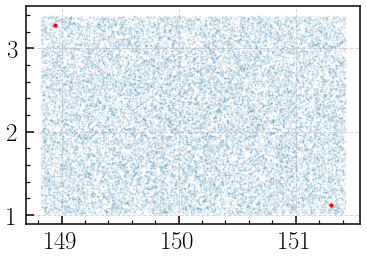

In [116]:
plt.scatter(cos_cat['RA'], cos_cat['DEC'], s=1, alpha=0.1)

ra_0, dec_0 = cosmos_wcs.all_pix2world(0, 0, 1)
ra_1, dec_1 = cosmos_wcs.all_pix2world(ra_size, dec_size, 1)
plt.scatter(ra_0, dec_0, s=10, c='r')
plt.scatter(ra_1, dec_1, s=10, c='r')

In [77]:
cosmos_cut.write('/Users/song/work/merian/cosmos/cosmos_ps1_refcat.fits', overwrite=True)

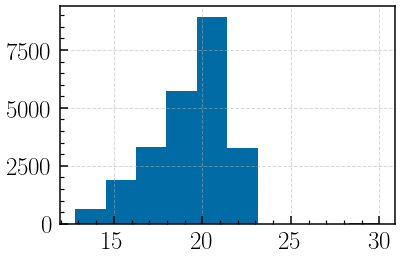

In [121]:
np.min(cosmos_cut['MEDIAN'], axis=0)

_ = plt.hist(cosmos_cut['MEDIAN'][:, 1])

In [99]:
cosmos_cut['NMAG_OK'][0]

array([14,  8, 10, 10,  8], dtype=int16)

In [123]:
ps1_cat = catalog.ReferenceCatalog(PS1_DIR, catalog.PS1_PATTERN)

cos_cat = ps1_cat.get_stars_hdu(cosmos_deep[1])

In [124]:
len(cos_cat)

23815